# The Architect's Co-Pilot for Adaptive Retail Design with GCP and Gemini

In [16]:

# !python -m pip install --quiet python-dotenv google-generativeai pinecone pypdf tiktoken langgraph pydantic pytrends mlflow matplotlib langchain-pinecone


In [17]:
import os, json, time, math, random
from typing import List, Dict, Any, Optional, TypedDict

from dotenv import load_dotenv; load_dotenv()
import google.generativeai as genai

from pinecone import Pinecone, ServerlessSpec
from pypdf import PdfReader

import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pydantic import BaseModel
from langgraph.graph import StateGraph, END
import re
try:
    from pytrends.request import TrendReq
    PYTRENDS_AVAILABLE = True
except Exception:
    PYTRENDS_AVAILABLE = False

In [18]:
required_env = [
    "GOOGLE_API_KEY",
    "GOOGLE_GENAI_USE_VERTEXAI",
    "GOOGLE_CLOUD_LOCATION",
    "GOOGLE_CLOUD_PROJECT",
    "PINECONE_API_KEY"
]
missing = [k for k in required_env if not os.getenv(k)]
if missing:
    raise EnvironmentError("Missing env vars: %s" % missing)
assert os.getenv("GOOGLE_GENAI_USE_VERTEXAI") == "False"

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
EMBED_MODEL = "text-embedding-004"
GEN_MODEL   = "gemini-2.0-flash"
GEN_CONFIG = {"response_mime_type": "application/json"}
PINECONE_INDEX_NAME = "blue-retail-docs"
PINECONE_CLOUD = "aws"
PINECONE_REGION = "us-east-1"
VECTOR_DIM = 768
SAFE_INGEST = True            
SKIP_INGEST_IF_INDEX_NONEMPTY = True
MAX_PDF_PAGES = 30            
MAX_CHUNKS_TOTAL = 360 
BATCH_SIZE = 8        
EMBED_CACHE_DIR = "./cache/embeddings"
os.makedirs(EMBED_CACHE_DIR, exist_ok=True)
DOCS_DIR = "./docs"; OUTPUTS_DIR = "./outputs"; ARTIFACT_DIR = "./artifacts"
os.makedirs(DOCS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [19]:
def sha256_text(s):
    """Return a hex SHA-256 hash for the given UTF-8 string."""
    import hashlib
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def read_pdf_text(path):
    """Extract text per page from a PDF file.

    Args:
        path: Filesystem path to a PDF.

    Returns:
        List of dicts like {"page": int, "text": str} for each page.
    """
    pages=[]
    with open(path, "rb") as f:
        pdf = PdfReader(f)
        for i, page in enumerate(pdf.pages, start=1):
            try:
                txt = page.extract_text() or ""
            except Exception:
                txt = ""
            pages.append({"page": i, "text": txt})
    return pages

def read_txt(path):
    """Read a text file as UTF-8 (with errors ignored) and return its contents."""
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def recursive_chunk(text, max_chars=1600, overlap=160):
    """Split large text into overlapping chunks.

    Args:
        text: Source text.
        max_chars: Target chunk size in characters.
        overlap: Characters of backward overlap between consecutive chunks.

    Returns:
        List of non-empty chunk strings.
    """
    chunks=[]; i=0; n=len(text)
    while i<n:
        end=min(i+max_chars,n); chunk=text[i:end]; chunks.append(chunk.strip()); i=end-overlap
        if i<0: i=0
        if i>=n: break
    return [c for c in chunks if c]

def detect_doctype(path):
    """Guess a coarse document type label from a file path (brand/fixture/lease/nbc/...).

    Args:
        path: File path.

    Returns:
        Lowercase type label used as metadata.
    """
    name=os.path.basename(path).lower()
    if "brand" in name: return "brand"
    if "fixture" in name: return "fixture"
    if "leasing" in name or "lease" in name: return "lease"
    if "accessibility" in name or "nbc" in name: return "nbc"
    if name.endswith(".md"): return "best_practices"
    if name.endswith(".txt"): return "text"
    if name.endswith(".pdf"): return "pdf"
    return "other"

def _embed_cache_path(txt_hash, model):
    """Build a deterministic cache file path for an embedding vector.

    Args:
        txt_hash: Hex hash of the text content.
        model: Embedding model id.

    Returns:
        Path to a JSON file storing the embedding.
    """
    safe_model = model.replace("/", "_")
    return os.path.join(EMBED_CACHE_DIR, f"{txt_hash}__{safe_model}.json")

def embed_texts(texts, model=EMBED_MODEL, max_retries=5, sleep_base=0.8):
    """Get embeddings for a list of texts with on-disk caching and retries.

    Args:
        texts: List of strings to embed.
        model: Embedding model id.
        max_retries: Max API retry attempts per text.
        sleep_base: Base backoff (seconds) for exponential retry.

    Returns:
        List of embedding vectors (list[float]).
    """
    out = []
    for t in texts:
        th = sha256_text(t)
        cache_file = _embed_cache_path(th, model)

        if os.path.exists(cache_file):
            try:
                with open(cache_file, "r") as f:
                    obj = json.load(f)
                out.append(obj["embedding"])
                continue
            except Exception:
                pass 

        attempt = 0
        while True:
            try:
                resp = genai.embed_content(model=model, content=t)
                vec = resp["embedding"]
                out.append(vec)
                # write cache
                with open(cache_file, "w") as f:
                    json.dump({"embedding": vec}, f)
                break
            except Exception:
                attempt += 1
                if attempt >= max_retries:
                    raise
                time.sleep(sleep_base * (2 ** (attempt - 1)))
    return out

def iter_doc_chunks(paths, chunk_size=1600, overlap=160):
    """Yield chunked text samples with metadata from a list of document paths.

    Args:
        paths: Iterable of file paths (.pdf/.txt/.md).
        chunk_size: Max characters per chunk.
        overlap: Overlap between chunks.

    Yields:
        Tuple (chunk_id, chunk_text, metadata_dict).
    """
    produced = 0
    for p in paths:
        if not os.path.exists(p):
            print("[WARN] Missing:", p); continue
        doctype = detect_doctype(p)
        base = os.path.basename(p)

        if p.lower().endswith(".pdf"):
            pages = read_pdf_text(p)
            if SAFE_INGEST:
                pages = pages[:MAX_PDF_PAGES]
            for page_obj in pages:
                page = page_obj["page"]; text = (page_obj["text"] or "").strip()
                if not text: 
                    continue
                for i, ch in enumerate(recursive_chunk(text, max_chars=chunk_size, overlap=overlap)):
                    h = sha256_text(ch)[:24]
                    cid = f"{h}__{base}__p{page}__c{i}"
                    meta = {"source_document": base, "doctype": doctype, "page": page}
                    yield cid, ch, meta
                    produced += 1
                    if SAFE_INGEST and produced >= MAX_CHUNKS_TOTAL:
                        return
        else:
            content = read_txt(p).strip()
            if not content: 
                continue
            for i, ch in enumerate(recursive_chunk(content, max_chars=chunk_size, overlap=overlap)):
                h = sha256_text(ch)[:24]
                cid = f"{h}__{base}__c{i}"
                meta = {"source_document": base, "doctype": doctype}
                yield cid, ch, meta
                produced += 1
                if SAFE_INGEST and produced >= MAX_CHUNKS_TOTAL:
                    return

def _index_vectors_check():
    """Quickly detect if the Pinecone index already contains vectors.

    Returns:
        True if a trivial query returns matches; False otherwise.
    """
    try:
        res = index.query(vector=[0.0]*VECTOR_DIM, top_k=1)
        return bool(res.get("matches"))
    except Exception:
        return False

def ingest_documents(paths, batch_size=BATCH_SIZE):
    """Chunk, embed, and upsert documents into Pinecone (with caps and skip-if-nonempty).

    Args:
        paths: Iterable of document file paths.
        batch_size: Number of chunks to embed/upsert per batch.
    """
    if SKIP_INGEST_IF_INDEX_NONEMPTY and _index_vectors_check():
        print("[INGEST] Skipped (index already has vectors).")
        return

    buffer_ids, buffer_texts, buffer_meta = [], [], []
    total = 0
    print(f"[INGEST] starting… caps: pages={MAX_PDF_PAGES}, chunks={MAX_CHUNKS_TOTAL}, batch={BATCH_SIZE}")

    for cid, ch, meta in iter_doc_chunks(paths, chunk_size=1600, overlap=160):
        buffer_ids.append(cid); buffer_texts.append(ch); buffer_meta.append(meta)
        if len(buffer_texts) >= batch_size:
            vecs = embed_texts(buffer_texts)
            up = []
            for _id, _vec, _meta, _txt in zip(buffer_ids, vecs, buffer_meta, buffer_texts):
                m = dict(_meta); m.update({"hash": sha256_text(_txt), "len": len(_txt)})
                up.append({"id": _id, "values": _vec, "metadata": m})
            index.upsert(vectors=up)
            total += len(up)
            print(f"[INGEST] Upserted total={total} (last batch={len(up)})")
            buffer_ids.clear(); buffer_texts.clear(); buffer_meta.clear()
            time.sleep(0.05)

    if buffer_texts:
        vecs = embed_texts(buffer_texts)
        up = []
        for _id, _vec, _meta, _txt in zip(buffer_ids, vecs, buffer_meta, buffer_texts):
            m = dict(_meta); m.update({"hash": sha256_text(_txt), "len": len(_txt)})
            up.append({"id": _id, "values": _vec, "metadata": m})
        index.upsert(vectors=up)
        total += len(up)
        print(f"[INGEST] Upserted total={total} (last batch={len(up)})")

    print(f"[INGEST] Done. Total chunks this run: {total}")

def pinecone_search(query, top_k=8, filter_meta=None):
    """Semantic search over the Pinecone index using a fresh query embedding.

    Args:
        query: Natural language query.
        top_k: Number of results to return.
        filter_meta: Optional metadata filter dict.

    Returns:
        Pinecone query response dict (with matches and metadata).
    """
    qv = embed_texts([query])[0]
    return index.query(vector=qv, top_k=top_k, include_metadata=True, filter=filter_meta or {})

In [20]:
def _is_429(err: Exception) -> bool:
    """Heuristic check if an Exception represents an HTTP 429 (Too Many Requests)."""
    s = str(err).lower()
    return "429" in s or "too many requests" in s


def _retry_pytrends(call_fn, *, max_retries=5, base_sleep=1.0, jitter=0.35, escalate=1.8):
    """Retry wrapper with exponential backoff + jitter for pytrends calls.

    Args:
        call_fn: Zero-arg callable to execute.
        max_retries: Max attempts.
        base_sleep: Initial backoff in seconds.
        jitter: Random jitter added to each delay.
        escalate: Exponential multiplier per attempt.

    Returns:
        Result of call_fn if successful.

    Raises:
        The last exception after exhausting retries.
    """
    attempt = 0
    while True:
        try:
            return call_fn()
        except Exception as e:
            attempt += 1
            if attempt >= max_retries:
                raise
            # sleep with backoff + jitter to avoid 429
            delay = (base_sleep * (escalate ** (attempt - 1))) + random.random() * jitter
            time.sleep(delay)

def make_trends_client():
    """Create and return a configured pytrends TrendReq client, or None if mocked/unavailable.

    Returns:
        TrendReq instance or None.
    """
    if MOCK_ANALYST or not PYTRENDS_AVAILABLE:
        return None
    try:
        return TrendReq(
            hl='en-US',
            tz=330,
            retries=None,         
            backoff_factor=0,    
            requests_args={
                "headers": {
                    "User-Agent": (
                        "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                        "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
                    )
                },
                "timeout": (5, 15),
            },
        )
    except TypeError:
        # Fallback for older pytrends signatures
        return TrendReq(hl='en-US', tz=330)


def _mock_interest_over_time(keywords, periods=168, freq='H'):
    """Generate synthetic hourly interest time series for given keywords.

    Args:
        keywords: List of keyword strings.
        periods: Number of time steps.
        freq: Pandas frequency string (e.g., 'H').

    Returns:
        DataFrame indexed by datetime with one column per keyword and 'isPartial' flag.
    """
    idx = pd.date_range(end=pd.Timestamp.now().floor('H'), periods=periods, freq=freq)
    data = {}
    for kw in keywords:
        base = random.randint(20, 60)
        noise = pd.Series([random.randint(-5, 5) for _ in range(periods)], index=idx).cumsum()
        season = pd.Series([max(0, int(15*abs((i/10)))) for i in range(periods)], index=idx)
        series = pd.Series(base, index=idx) + noise + season
        series = series.clip(lower=0)
        data[kw] = series
    df = pd.DataFrame(data); df.index.name = "datetime"; df["isPartial"] = False
    return df

def _mock_related_queries(keywords):
    """Return synthetic 'top' and 'rising' related query DataFrames for each keyword.

    Args:
        keywords: List of keyword strings.

    Returns:
        Dict[keyword] -> {"top": DataFrame, "rising": DataFrame}.
    """
    mock = {}
    for kw in keywords:
        mock[kw] = {
            "top": pd.DataFrame({
                "query": [f"{kw} price", f"{kw} review", f"{kw} specs", f"best alternative to {kw}"],
                "value": [100, 85, 77, 64]
            }),
            "rising": pd.DataFrame({
                "query": [f"{kw} discount", f"{kw} exchange offer", f"{kw} vs competitor"],
                "value": [800, 540, 420]
            })
        }
    return mock

def fetch_interest_over_time(pytrend, keywords, geo, timeframe, gprop):
    """Fetch Google Trends interest-over-time for keywords (or mock if offline/blocked).

    Args:
        pytrend: TrendReq client or None.
        keywords: List of keywords.
        geo: Country/region code (e.g., 'IN').
        timeframe: Trends timeframe (e.g., 'now 7-d').
        gprop: Google property ('', 'news', 'images', 'youtube', 'froogle').

    Returns:
        DataFrame with interest indices per keyword and 'isPartial' column.
    """
    if MOCK_ANALYST or pytrend is None:
        return _mock_interest_over_time(keywords, periods=7*24, freq='H')

    def _do():
        pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
        time.sleep(1.2)
        return pytrend.interest_over_time()

    return _retry_pytrends(_do, max_retries=5, base_sleep=1.0, jitter=0.4, escalate=2.0)


def fetch_related_queries(pytrend, keywords, geo, timeframe, gprop):
    """Fetch Google Trends related queries for keywords (or mock if offline/blocked).

    Args:
        pytrend: TrendReq client or None.
        keywords: List of keywords.
        geo: Region for payload.
        timeframe: Trends timeframe.
        gprop: Google property.

    Returns:
        Dict[keyword] -> {"top": DataFrame, "rising": DataFrame}.
    """
    if MOCK_ANALYST or pytrend is None:
        return _mock_related_queries(keywords)

    def _do():
        pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=geo, gprop=gprop)
        time.sleep(1.2)
        return pytrend.related_queries()

    return _retry_pytrends(_do, max_retries=5, base_sleep=1.0, jitter=0.4, escalate=2.0)


def fetch_state_interest(pytrend, keywords, sub_geo, timeframe, gprop):
    """Fetch state-level Google Trends interest-over-time (or mock if offline/blocked).

    Args:
        pytrend: TrendReq client or None.
        keywords: List of keywords.
        sub_geo: Sub-region code (e.g., 'IN-GJ').
        timeframe: Trends timeframe.
        gprop: Google property.

    Returns:
        DataFrame with interest indices per keyword and 'isPartial' column.
    """
    if MOCK_ANALYST or pytrend is None:
        return _mock_interest_over_time(keywords, periods=7*24, freq='H')

    def _do():
        pytrend.build_payload(kw_list=keywords, timeframe=timeframe, geo=sub_geo, gprop=gprop)
        time.sleep(1.2)
        return pytrend.interest_over_time()

    return _retry_pytrends(_do, max_retries=5, base_sleep=1.0, jitter=0.4, escalate=2.0)

def fetch_realtime_trends(pytrend, geo="IN"):
    """
    Fetch country-level realtime trending searches from Google Trends, with safe fallbacks.

    Behavior:
      - If MOCK mode is active or `pytrend` is None, returns a small mock DataFrame (offline-friendly).
      - Tries `pytrend.realtime_trending_searches(pn=geo)` first; if unavailable, falls back to
        `pytrend.trending_searches(pn="india")`.
      - Wrapped in `_retry_pytrends` (exponential backoff + jitter) to avoid freezes on 429/temporary errors.

    Args:
        pytrend: An initialized `pytrends.request.TrendReq` client or `None` (mock/offline).
        geo (str): Country code for realtime trends (e.g., "IN"). Ignored in mock mode.

    Returns:
        pandas.DataFrame: Top realtime (or fallback) trending searches, with columns such as
        'title', 'entity_names', and 'traffic' when available. If both live and fallback fail,
        a mock DataFrame is returned when MOCK mode is on; otherwise, an empty DataFrame may be returned.

    Notes:
        - This function is optional; it's safe to call and will not halt the pipeline on rate limits.
        - Use `include_realtime=True` in `run_market_analyst(...)` to attach these rows to the payload.
    """
    if MOCK_ANALYST or pytrend is None:
        # Reference offline-friendly mock
        return pd.DataFrame({
            "title": ["Festive sale electronics", "iPhone 16 rumors", "Noise ANC Pro 2", "OLED TV deals"],
            "entity_names": [["sale"], ["iphone"], ["headphones"], ["tv"]],
            "traffic": [100000, 82000, 45000, 39000],
        })
    def _do():
        try:
            # Some pytrends builds have realtime; if not, fall back
            df = pytrend.realtime_trending_searches(pn=geo)
            return df
        except Exception:
            return pytrend.trending_searches(pn="india")
    return _retry_pytrends(_do, max_retries=5, base_sleep=1.0, jitter=0.4, escalate=2.0)


def package_signals(iot_df, state_df, rq_top_df, city_hint="Surat", state_code="IN-GJ"):
    """Assemble a normalized market signal payload for downstream agents.

    Args:
        iot_df: Interest over time DataFrame (national).
        state_df: Interest over time DataFrame (state proxy).
        rq_top_df: Flattened top related queries DataFrame.
        city_hint: Display city name for metadata.
        state_code: Sub-region code (e.g., 'IN-GJ').

    Returns:
        Dict payload with 'market' and 'signals' keys.
    """
    def top_keyword(df, window=-48):
        sub = df.iloc[window:] if len(df) + window > 0 else df
        cols = [c for c in sub.columns if c != "isPartial"]
        means = sub[cols].mean().sort_values(ascending=False)
        return [{"keyword": k, "score": float(v)} for k, v in means.items()]
    payload = {
        "as_of": pd.Timestamp.utcnow().isoformat() + "Z",
        "market": {"country": "IN", "state": state_code, "city_proxy": city_hint},
        "signals": {
            "interest_over_time_national": top_keyword(iot_df),
            "interest_over_time_state": top_keyword(state_df),
            "related_queries_top": rq_top_df.head(50).to_dict(orient="records")
        }
    }
    return payload

def run_market_analyst(keywords,geo="IN",sub_geo="IN-GJ",timeframe="now 7-d",gprop="froogle",mock=False,city_hint="Surat",include_realtime=False):
    """End-to-end Trends fetch with automatic 429 fallback to mock data.

    Args:
        keywords: List of product keywords.
        geo: Country/region code.
        sub_geo: State/sub-region code (city proxy).
        timeframe: Trends timeframe.
        gprop: Google property.
        mock: Force mock mode if True.
        city_hint: City label for metadata packaging.

    Returns:
        Dict with a single key 'payload' containing packaged signals.
    """
    global MOCK_ANALYST
    MOCK_ANALYST = mock
    pytrend = make_trends_client()

    try:
        iot_df  = fetch_interest_over_time(pytrend, keywords, geo, timeframe, gprop)
        state_df = fetch_state_interest(pytrend, keywords, sub_geo, timeframe, gprop)
        rq      = fetch_related_queries(pytrend, keywords, geo, timeframe, gprop)
        rt_df   = None
        if include_realtime:
            try:
                rt_df = fetch_realtime_trends(pytrend, geo=geo)
            except Exception as e:
                print("[WARN] realtime trends disabled:", e)
                rt_df = None
    except Exception as e:
        if not mock and _is_429(e):
            print("[WARN] Google Trends rate-limited (429). Falling back to MOCK mode for this run.")
            MOCK_ANALYST = True
            pytrend = None
            iot_df  = fetch_interest_over_time(pytrend, keywords, geo, timeframe, gprop)
            state_df = fetch_state_interest(pytrend, keywords, sub_geo, timeframe, gprop)
            rq      = fetch_related_queries(pytrend, keywords, geo, timeframe, gprop)
            rt_df   = fetch_realtime_trends(pytrend, geo=geo) if include_realtime else None
        else:
            raise

    # flatten related queries
    rows = []
    for kw, parts in rq.items():
        top_df = parts.get("top")
        if isinstance(top_df, pd.DataFrame):
            for _, r in top_df.iterrows():
                rows.append({"keyword": kw, "query": r["query"], "value": int(r["value"])})
    rq_top_df = pd.DataFrame(rows).sort_values(["keyword", "value"], ascending=[True, False]).reset_index(drop=True)

    payload = package_signals(iot_df, state_df, rq_top_df, city_hint=city_hint, state_code=sub_geo)

    if include_realtime and isinstance(rt_df, pd.DataFrame):
        payload.setdefault("signals", {})["realtime_trends"] = rt_df.head(20).to_dict(orient="records")
    else:
        payload.setdefault("signals", {})["realtime_trends"] = []

    iot_df.to_csv(os.path.join(ARTIFACT_DIR, "interest_over_time_latest.csv"))
    state_df.to_csv(os.path.join(ARTIFACT_DIR, f"interest_over_time_{sub_geo}_latest.csv"))
    rq_top_df.to_csv(os.path.join(ARTIFACT_DIR, "related_queries_top_latest.csv"), index=False)
    return {"payload": payload}


def market_signals_to_weights(payload):
    """Convert packaged market signals into normalized category weights (0..1).

    Args:
        payload: Dict as returned by package_signals/run_market_analyst.

    Returns:
        Dict category -> weight (e.g., {'mobiles': 1.0, 'laptops': 0.4, ...}).
    """
    state_top = payload["signals"].get("interest_over_time_state", [])
    if not state_top:
        state_top = payload["signals"].get("interest_over_time_national", [])

    def cat_for(kw):
        k = kw.lower()
        if any(x in k for x in ["iphone", "galaxy", "mobile", "phone"]): return "mobiles"
        if any(x in k for x in ["laptop", "macbook"]): return "laptops"
        if any(x in k for x in ["headphone", "earbud", "audio", "anc", "soundbar"]): return "audio"
        if any(x in k for x in ["gaming", "console", "ps5", "xbox", "nintendo"]): return "gaming"
        if any(x in k for x in ["fridge", "air conditioner", "washing", "tv", "ac "]): return "appliances"
        return "mobiles"

    bucket = {"mobiles":0.0,"laptops":0.0,"audio":0.0,"gaming":0.0,"appliances":0.0}
    for item in state_top:
        bucket[cat_for(item["keyword"])] += float(item["score"])
    for rq in payload["signals"].get("related_queries_top", [])[:50]:
        bucket[cat_for(rq["query"])] += rq.get("value", 0) * 0.2

    mx = max(bucket.values()) if bucket else 1.0
    if mx == 0: mx = 1.0
    return {k: round(v/mx, 2) for k, v in bucket.items()}

In [21]:
def build_context_from_matches(matches, max_lines=20):
    """Summarize Pinecone matches into a compact citation string.

    Args:
        matches: Pinecone match list (with metadata).
        max_lines: Max rows to include.

    Returns:
        Multi-line string of '[chunk_id] source p.page' entries.
    """
    lines=[]
    for m in matches[:max_lines]:
        md=m.get("metadata",{}); src=md.get("source_document","unknown"); page=md.get("page","?")
        lines.append("[%s] %s p.%s" % (m["id"], src, page))
    return "\n".join(lines)

def _first_json_block(s):
    """Extract the first JSON object from a string (handles optional ```json fences).

    Args:
        s: Raw model output string.

    Returns:
        The JSON substring if found, else None.
    """
    if not s:
        return None
    fence = re.search(r"```(?:json)?\s*({.*?})\s*```", s, flags=re.S)
    if fence:
        return fence.group(1)
    brace = re.search(r"({.*})", s, flags=re.S)
    if brace:
        return brace.group(1)
    return None

def parse_layout_json(text_or_obj):
    """Parse model output into a Python dict, tolerating fenced or extra text.

    Args:
        text_or_obj: Model response object or raw string.

    Returns:
        Dict parsed from JSON.

    Raises:
        Exception if no valid JSON can be extracted.
    """
    if isinstance(text_or_obj, dict):
        return text_or_obj
    if hasattr(text_or_obj, "text"):
        payload = text_or_obj.text
    else:
        payload = str(text_or_obj)
    try:
        return json.loads(payload)
    except Exception:
        cleaned = _first_json_block(payload)
        if cleaned:
            return json.loads(cleaned)
        raise


def strategist_generate_layout(city, floor_area_sqm, entry_points, trend_weights, top_k=12, corridor_min_m=1.2):
    """RAG-augmented layout planning: retrieve, prompt Gemini for JSON, validate, fallback.

    Args:
        city: Target city name.
        floor_area_sqm: Total floor area in square meters.
        entry_points: List of site entry point dicts.
        trend_weights: Category weights (0..1).
        top_k: Number of RAG chunks to retrieve.
        corridor_min_m: Minimum corridor width requirement.

    Returns:
        LayoutPlan Pydantic model (with citations and optional fallback).
    """
    matches = pinecone_search(
        "layout constraints for %s; NBC; lease; brand rules; fixtures" % city,
        top_k=top_k
    ).get("matches", [])

    citations = [
        {"chunk_id": m.get("id"),
         "source_document": m.get("metadata", {}).get("source_document"),
         "page": m.get("metadata", {}).get("page")}
        for m in matches
    ]
    retrieval_context = build_context_from_matches(matches)

    schema_hint = {
        "site": {"city": city, "floor_area_sqm": floor_area_sqm, "dimensions_m": {"width": 20.0, "height": 12.0}, "entry_points": entry_points},
        "zoning": [{"zone_id":"Z?","name":"?","priority":0.0,"area_sqm":0.0,"rect":{"x":0.0,"y":0.0,"w":0.0,"h":0.0}}],
        "fixtures": [{"fixture_id":"?","zone_id":"?","x":0.0,"y":0.0,"w":0.0,"h":0.0,"rotation_deg":0}],
        "paths": {"min_corridor_width_m": corridor_min_m, "corridors":[{"x":0.0,"y":0.0,"w":0.0,"h":0.0}]},
        "constraints": {"brand_rules":[],"lease":[],"nbc_accessibility":[]},
        "citations": citations
    }

    user_prompt = (
        "You are the Layout Strategist for a premium electronics retailer.\n"
        "Use ONLY the retrieved document IDs and trend weights to produce a compliant conceptual layout.\n"
        "Return STRICT JSON with keys: site, zoning, fixtures, paths, constraints, citations.\n"
        "No prose. No markdown. JSON ONLY.\n\n"
        "Retrieved chunks (IDs only):\n%s\n\n"
        "Inputs:\nCity: %s\nFloor area (sqm): %s\nEntry points: %s\n"
        "Trend weights (0..1): %s\nMin corridor width: %s m\n\n"
        "JSON schema hint (shape only, fill values appropriately):\n%s"
        % (retrieval_context, city, floor_area_sqm, entry_points, trend_weights, corridor_min_m, json.dumps(schema_hint))
    )

    model = genai.GenerativeModel(GEN_MODEL, generation_config=GEN_CONFIG)

    last_err = None
    for _ in range(3):
        try:
            resp = model.generate_content([user_prompt])
            data = parse_layout_json(resp)
            plan = LayoutPlan(**data)
            if not plan.citations:
                plan.citations = citations
            return plan
        except Exception as e:
            last_err = e
            time.sleep(0.8)

    # FINAL FALLBACK (don’t crash the graph)
    # Use a small baseline plan if the model response cannot be parsed.
    plan = LayoutPlan(
        site={"city": city, "floor_area_sqm": floor_area_sqm, "dimensions_m": {"width": 20.0, "height": 12.0}, "entry_points": entry_points},
        zoning=[
            {"zone_id":"Z1","name":"Mobiles","priority":0.9,"area_sqm":60.0,"rect":{"x":1.0,"y":6.5,"w":9.0,"h":4.5}},
            {"zone_id":"Z2","name":"Laptops","priority":0.8,"area_sqm":50.0,"rect":{"x":1.0,"y":1.0,"w":9.0,"h":4.5}},
            {"zone_id":"Z3","name":"Audio","priority":0.6,"area_sqm":35.0,"rect":{"x":11.0,"y":1.0,"w":8.0,"h":5.0}}
        ],
        fixtures=[
            {"fixture_id":"FX-Table-120x80","zone_id":"Z1","x":2.0,"y":7.0,"w":1.2,"h":0.8},
            {"fixture_id":"FX-Table-120x80","zone_id":"Z2","x":2.0,"y":2.0,"w":1.2,"h":0.8},
            {"fixture_id":"FX-Wall-Display","zone_id":"Z3","x":11.0,"y":1.0,"w":0.5,"h":5.0}
        ],
        paths={"min_corridor_width_m": corridor_min_m, "corridors":[{"x":1.0,"y":5.7,"w":18.0,"h":1.2}]},
        constraints={"brand_rules": [], "lease": [], "nbc_accessibility": []},
        citations=citations
    )
    return plan


def compliance_check(plan):
    """Apply lightweight rule checks (e.g., corridor widths) to a LayoutPlan.

    Args:
        plan: LayoutPlan instance.

    Returns:
        ComplianceReport with violations listed if any.
    """
    min_w = plan.paths.get("min_corridor_width_m", 1.2)
    violations=[]
    for c in plan.paths.get("corridors", []):
        width=min(c["w"], c["h"])
        if width < min_w:
            violations.append({"type":"corridor_width","required_m":float(min_w),"actual_m":float(width),"location":c})
    ok = len(violations)==0
    return ComplianceReport(brand_rules_ok=True, lease_ok=True, nbc_ok=ok, violations=violations)

def render_layout_png(plan, out_path):
    """Render a simple 2D diagram for the layout plan and save as PNG.

    Args:
        plan: LayoutPlan instance.
        out_path: Output PNG path (written to disk).
    """
    site=plan.site
    dims=site.get("dimensions_m") or {"width": math.sqrt(site.get("floor_area_sqm", 200)),
                                      "height": math.sqrt(site.get("floor_area_sqm", 200))/1.5}
    W=dims["width"]; H=dims["height"]
    fig,ax=plt.subplots(figsize=(10,6)); ax.add_patch(Rectangle((0,0),W,H,fill=False,linewidth=2))
    for e in site.get("entry_points", []):
        ax.add_patch(Rectangle((e["x"], e["y"]-0.1),0.2,0.2,fill=True)); ax.text(e["x"]+0.25,e["y"],"Entry %s" % e["id"],va='center')
    for z in plan.zoning:
        r=z.rect; ax.add_patch(Rectangle((r.x,r.y),r.w,r.h,fill=False)); ax.text(r.x+r.w/2,r.y+r.h/2,z.name,ha='center',va='center',fontsize=9)
    for fx in plan.fixtures:
        ax.add_patch(Rectangle((fx.x,fx.y),fx.w,fx.h,fill=True)); ax.text(fx.x+fx.w/2,fx.y+fx.h/2,fx.fixture_id,ha='center',va='center',fontsize=6)
    for c in plan.paths.get("corridors", []):
        ax.add_patch(Rectangle((c["x"],c["y"]),c["w"],c["h"],fill=False,linestyle='--')); ax.text(c["x"]+c["w"]/2,c["y"]+c["h"]/2,'Corridor',ha='center',va='center',fontsize=7)
    ax.set_xlim(0,W); ax.set_ylim(0,H); ax.set_aspect('equal', adjustable='box'); ax.set_title("Conceptual Layout – %s" % site.get('city',''))
    ax.set_xlabel("Meters (X)"); ax.set_ylabel("Meters (Y)"); plt.tight_layout(); plt.savefig(out_path,dpi=150); plt.close(fig)

def log_run_to_mlflow(city, trend_weights, plan, png_path, index_name):
    """Log parameters, metrics, and artifacts for a layout run to MLflow.

    Args:
        city: City label.
        trend_weights: Dict of category weights.
        plan: LayoutPlan instance.
        png_path: Path to rendered PNG.
        index_name: Pinecone index name (for traceability).
    """
    mlflow.set_tracking_uri("http://20.75.92.162:5000/")
    mlflow.set_experiment("Team_7_Capstone_2_Architect_Copilot_Retail_Capstone")
    with mlflow.start_run(run_name="layout_%s" % city):
        mlflow.log_param("city", city); mlflow.log_param("index", index_name)
        mlflow.log_param("embed_model", EMBED_MODEL); mlflow.log_param("gen_model", GEN_MODEL)
        mlflow.log_param("corridor_min_m", plan.paths.get("min_corridor_width_m", 1.2))
        for k,v in trend_weights.items(): mlflow.log_param("trend_%s" % k, v)
        comp = plan.compliance_report.model_dump() if plan.compliance_report else {}
        mlflow.log_metric("nbc_ok", int(comp.get("nbc_ok", 0)))
        mlflow.log_metric("violations_count", len(comp.get("violations", [])) if comp else 0)
        json_path=os.path.join("./outputs", "layout_plan_%s.json" % city)
        with open(json_path,"w") as f: json.dump(plan.model_dump(), f, indent=2)
        mlflow.log_artifact(json_path)
        if os.path.exists(png_path): mlflow.log_artifact(png_path)

In [22]:
class EntryPoint(BaseModel):
    """Site entry definition used by the plan (position and width in meters)."""
    id: str
    x: float
    y: float
    width_m: float

class ZoneRect(BaseModel):
    """Axis-aligned rectangle (x, y, w, h) in meters defining a zone's footprint."""
    x: float
    y: float
    w: float
    h: float

class Zone(BaseModel):
    """A functional area in the store with priority, area target, and bounding rect."""
    zone_id: str
    name: str
    priority: float
    area_sqm: float
    rect: ZoneRect

class Fixture(BaseModel):
    """Placed fixture within a zone with dimensions and optional rotation."""
    fixture_id: str
    zone_id: str
    x: float
    y: float
    w: float
    h: float
    rotation_deg: float = 0

class ComplianceReport(BaseModel):
    """Validation outcome for brand/lease/NBC checks with a list of violations."""
    brand_rules_ok: bool
    lease_ok: bool
    nbc_ok: bool
    violations: List[Dict[str, Any]]

class LayoutPlan(BaseModel):
    """Complete conceptual layout: site, zones, fixtures, paths, constraints, citations."""
    site: Dict[str, Any]
    zoning: List[Zone]
    fixtures: List[Fixture]
    paths: Dict[str, Any]
    constraints: Dict[str, Any]
    citations: List[Dict[str, Any]]
    compliance_report: Optional[ComplianceReport] = None

In [23]:
class AppState(TypedDict, total=False):
    """Graph state passed between nodes: inputs, intermediate signals, and outputs."""
    city: str
    floor_area_sqm: float
    entry_points: List[Dict[str, Any]]
    trend_weights: Dict[str, float]
    plan: Any
    png_path: str
    geo: str          # "IN"
    sub_geo: str      # "IN-GJ" (state proxy for the city)
    gprop: str        # "", "news", "images", "youtube", "froogle"
    keywords: List[str]


def node_market_analyst(state):
    """
    LangGraph node: enriches AppState with market trend weights.

    Pulls keywords/geo settings from `state` (with sensible defaults), calls
    `run_market_analyst(...)` to fetch Google Trends based signals (auto-fallbacks
    to mock on 429), converts signals to category weights via
    `market_signals_to_weights(...)`, and stores them at `state["trend_weights"]`.

    Args:
        state (AppState): Mutable pipeline state with optional keys:
            - "keywords": List[str]
            - "geo": str (e.g., "IN")
            - "sub_geo": str (e.g., "IN-TN")
            - "timeframe": str (e.g., "now 7-d")
            - "gprop": str (e.g., "froogle")
            - "city": str (used as city_hint)

    Returns:
        AppState: Same dict with `trend_weights` added.
    """
    keywords = state.get("keywords") or ["iPhone 15","Samsung Galaxy S24","noise cancelling headphones","gaming laptop"]
    geo = state.get("geo", "IN")
    sub_geo = state.get("sub_geo", "IN-GJ")  # e.g., "IN-TN" for Chennai, "IN-MH" for Mumbai

    out = run_market_analyst(
        keywords=keywords,
        geo=geo,
        sub_geo=sub_geo,
        timeframe=state.get("timeframe", "now 7-d"),
        gprop=state.get("gprop", "froogle"),
        mock=False,
        city_hint=state.get("city"),
        include_realtime=True, 
    )
    weights = market_signals_to_weights(out["payload"])
    state["trend_weights"] = weights
    return state


In [24]:
def node_strategist(state):
    """
    LangGraph node: generates a compliant conceptual layout plan.

    Uses `strategist_generate_layout(...)` with the city, floor area, entry points,
    and `trend_weights` already present in `state`. Runs `compliance_check(...)`
    on the result and saves the validated `LayoutPlan` at `state["plan"]`.

    Requires in `state`:
        - "city": str
        - "floor_area_sqm": float
        - "entry_points": List[dict]
        - "trend_weights": Dict[str, float]

    Returns:
        AppState: Same dict with `plan` (LayoutPlan) added.
    """
    plan = strategist_generate_layout(
        city=state["city"],
        floor_area_sqm=state["floor_area_sqm"],
        entry_points=state["entry_points"],
        trend_weights=state["trend_weights"],
        top_k=12,
        corridor_min_m=1.2
    )
    plan.compliance_report = compliance_check(plan)
    state["plan"] = plan
    return state

def node_draftsman(state):
    """
    LangGraph node: renders artifacts and logs the run.

    Renders the `LayoutPlan` in `state["plan"]` to a PNG under ./outputs/,
    writes the layout JSON and trend weight JSON to ./outputs/, updates:
        - `state["png_path"]`
        - `state["json_path"]`
        - `state["weights_path"]`
    and logs artifacts/params to MLflow via `log_run_to_mlflow(...)`.

    Requires in `state`:
        - "city": str
        - "plan": LayoutPlan
        - "trend_weights": Dict[str, float]

    Side effects:
        - Creates/overwrites files in ./outputs/
        - Sends metrics/artifacts to MLflow

    Returns:
        AppState: Same dict with paths to generated files added.
    """
    out_png = "./outputs/layout_%s.png" % state["city"]
    render_layout_png(state["plan"], out_png)
    state["png_path"] = out_png

    json_path = "./outputs/layout_plan_%s.json" % state["city"]
    try:
        payload = state["plan"].model_dump() if hasattr(state["plan"], "model_dump") else state["plan"]
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(payload, f, indent=2)
        state["json_path"] = json_path
    except Exception as e:
        print("[WARN] Failed to write plan JSON:", e)

    weights_path = "./outputs/trend_weights_%s.json" % state["city"]
    try:
        with open(weights_path, "w", encoding="utf-8") as f:
            json.dump(state.get("trend_weights", {}), f, indent=2)
        state["weights_path"] = weights_path
    except Exception as e:
        print("[WARN] Failed to write weights JSON:", e)
    log_run_to_mlflow(state["city"], state["trend_weights"], state["plan"], out_png, PINECONE_INDEX_NAME)
    return state


In [25]:
graph = StateGraph(AppState)
graph.add_node("market_analyst", node_market_analyst)
graph.add_node("strategist", node_strategist)
graph.add_node("draftsman", node_draftsman)

graph.set_entry_point("market_analyst")
graph.add_edge("market_analyst", "strategist")
graph.add_edge("strategist", "draftsman")
graph.add_edge("draftsman", END)

app = graph.compile()

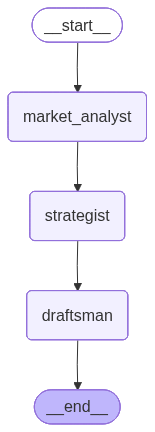

In [26]:
app

In [27]:
MOCK_ANALYST = False # False - real time, True - mocked up

In [28]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
existing = [idx["name"] for idx in pc.list_indexes()]
if PINECONE_INDEX_NAME not in existing:
    print("Creating Pinecone index...")
    pc.create_index(
        name=PINECONE_INDEX_NAME,
        dimension=VECTOR_DIM,
        metric="cosine",
        spec=ServerlessSpec(cloud=PINECONE_CLOUD, region=PINECONE_REGION),
    )
    while True:
        if pc.describe_index(PINECONE_INDEX_NAME).status["ready"]:
            break
        time.sleep(2)
index = pc.Index(PINECONE_INDEX_NAME)
print("Index ready:", PINECONE_INDEX_NAME)

Index ready: blue-retail-docs


In [29]:
DOC_PATHS = [
    "./docs/Blue_Retail_Brand_Book_v4.pdf",
    "./docs/Fixture_Catalog_Q3_2025.pdf",
    "./docs/National_Building_Code_Accessibility_Chapter.txt",
    "./docs/Store_Leasing_Agreement_Surat.pdf",
    "./docs/Retail_Design_Best_Practices.md",
]

In [30]:
ingest_documents(DOC_PATHS)

initial_state = {
    "city": "Surat",
    "floor_area_sqm": 240.0,
    "entry_points": [{"id":"E1","x":0.0,"y":6.0,"width_m":2.4}],
    "keywords": ["iPhone 15", "OnePlus 12", "Bluetooth headphones", "OLED TV"],
    "geo": "IN",
    "sub_geo": "IN-GJ",    
    # "timeframe": "now 7-d",
    # "gprop": "froogle",
}

final_state = app.invoke(initial_state)

print("Trend weights:", final_state.get("trend_weights"))
print("PNG saved:", final_state.get("png_path"))
print("Plan JSON saved.")

[INGEST] Skipped (index already has vectors).


/home/zadmin/Desktop/test/GAAI-B5-GCP/genai/lib/python3.11/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/home/zadmin/Desktop/test/GAAI-B5-GCP/genai/lib/python3.11/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


[WARN] realtime trends disabled: The request failed: Google returned a response with code 404


2025/10/10 03:56:52 INFO mlflow.tracking.fluent: Experiment with name 'Team_7_Capstone_2_Architect_Copilot_Retail_Capstone' does not exist. Creating a new experiment.


🏃 View run layout_Surat at: http://20.75.92.162:5000/#/experiments/196695771660628660/runs/971f3f5e768f4d199dff3bcab962fba2
🧪 View experiment at: http://20.75.92.162:5000/#/experiments/196695771660628660
Trend weights: {'mobiles': 1.0, 'laptops': 0.0, 'audio': 0.03, 'gaming': 0.0, 'appliances': 0.12}
PNG saved: ./outputs/layout_Surat.png
Plan JSON saved.
